In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import scipy
import scipy.stats
from tqdm import tqdm
import time
%pylab inline

plt.rcParams["figure.figsize"] = (10,7)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.12/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


### Решение в матричной форме

In [2]:
class OrdinaryLeastSquares:
    def __init__(self):
        pass

    def fit(self, X, y):
        """Находим веса линейной регрессии аналитическим методом.

        Parameters:
        X (numpy.ndarray): Матрица признаков.
        y (numpy.ndarray): Вектор целевых значений.

        Returns:
        None
        """
        self.weights = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))

    def predict(self, X):
        """С помощью найденных весов делаем предсказание.

        Parameters:
        X (numpy.ndarray): Матрица признаков для предсказания.

        Returns:
        numpy.ndarray: Предсказанные значения.
        """
        return np.dot(X, self.weights)

Веса функции:  [[3.00524094]
 [2.04931516]
 [0.03924625]]


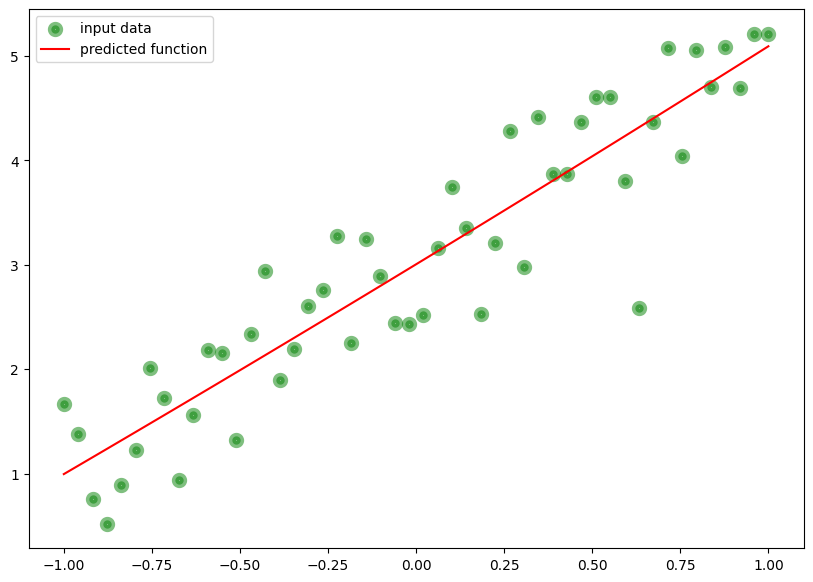

In [3]:
#определяем нашу независимую переменную
X = np.linspace(-1,1,50)
#и зависимую переменную
y_array = np.array([2 * (x + np.random.normal(0,0.25)) + 3 for x in X]).reshape(-1,1)
#формуруем матрицу признаков(design matrix) для обучения - не забываем добавить вектор 1, коэфициент при котором будет соответсвовать смещению
x_array = np.array([X**0, X**1, X**2]).T

#обучение модели
ols = OrdinaryLeastSquares()
ols.fit(x_array, y_array)

predictions = ols.predict(x_array)
print('Веса функции: ', ols.weights)

#визуализация предсказания и исходных данных
plt.scatter(X, y_array, label='input data', c = 'g',linewidths=5, alpha=0.5)
plt.plot(X, predictions, color='r',label='predicted function')
plt.legend()

### Решение итеративным способом аппроксимации квадратичной функции линейной регрессией

y_array:  (50, 1)
Weights:  [[ 4.99317574]
 [-0.00567037]
 [ 1.01154727]]
Number of iters:  10577


Text(0.5, 1.0, 'График ошибки')

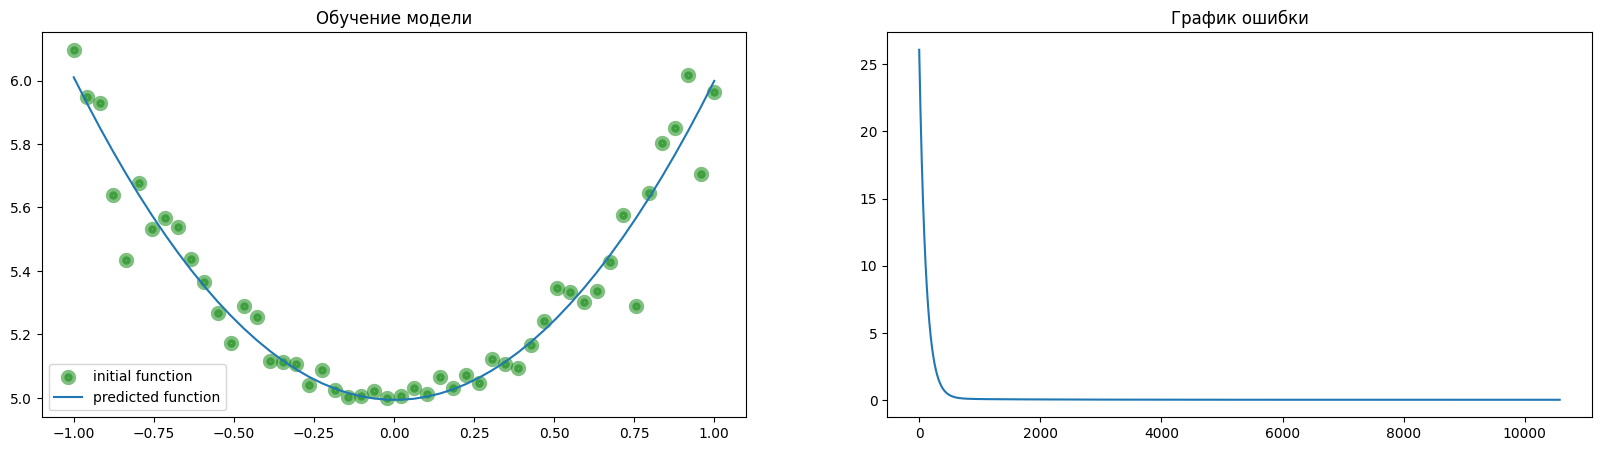

In [4]:
class IterativeLinearRegression:
    def __init__(self, learning_rate, iters):
        """
        Конструктор класса для итеративной линейной регрессии.

        Parameters:
        learning_rate (float): Скорость обучения (шаг градиентного спуска).
        iters (int): Максимальное количество итераций для обучения.

        Attributes:
        iters (int): Количество итераций.
        learning_rate (float): Скорость обучения.
        tol (float): Порог сходимости для разницы нормы весов между итерациями.
        weights (numpy.ndarray): Веса модели после обучения.
        """
        self.iters = iters
        self.learning_rate = learning_rate
        self.tol = 1e-5

    def fit_with_while(self, X, y):
        """
        Обучение линейной регрессии численным методом с использованием итераций до сходимости.

        Parameters:
        X (numpy.ndarray): Матрица признаков.
        y (numpy.ndarray): Вектор целевых значений.

        Returns:
        list: Список значений функции потерь на каждой итерации.
        """
        loss_list = []
        weights_list = []

        self.weights = np.random.rand(X.shape[1], 1)
        weights_list.append(self.weights)

        loss_grad = self.loss_grad(X, y)
        step = self.learning_rate * loss_grad / len(X)
        self.weights = self.weights - step
        weights_list.append(self.weights)

        i = 1
        while np.linalg.norm(weights_list[i] - weights_list[i - 1]) > self.tol:
            loss_grad = self.loss_grad(X, y)
            step = self.learning_rate * loss_grad / len(X)
            self.weights = self.weights - step
            loss = self.loss(X, y)
            loss_list.append(loss)
            weights_list.append(self.weights)
            i += 1
        return loss_list

    def fit(self, X, y):
        """
        Обучение линейной регрессии численным методом с использованием указанного количества итераций.

        Parameters:
        X (numpy.ndarray): Матрица признаков.
        y (numpy.ndarray): Вектор целевых значений.

        Returns:
        list: Список значений функции потерь на каждой итерации.
        """
        loss_list = []
        weights_list = []
        self.weights = np.random.rand(X.shape[1], 1)

        for _ in range(self.iters):
            loss_grad = self.loss_grad(X, y)
            step = self.learning_rate * loss_grad / len(X)
            self.weights = self.weights - step
            loss = self.loss(X, y)
            loss_list.append(loss)
        return loss_list

    def predict(self, X):
        """
        Выполнение предсказаний с использованием обученных весов.

        Parameters:
        X (numpy.ndarray): Матрица признаков для предсказания.

        Returns:
        numpy.ndarray: Предсказанные значения.
        """
        return np.dot(X, self.weights)

    def loss(self, X, y):
        """
        Вычисление среднеквадратичной ошибки.

        Parameters:
        X (numpy.ndarray): Матрица признаков.
        y (numpy.ndarray): Вектор целевых значений.

        Returns:
        float: Среднеквадратичная ошибка.
        """
        y_hat = np.dot(X, self.weights)
        loss = 1 / len(X) * np.sum((y_hat - y) ** 2)
        return loss

    def loss_grad(self, X, y):
        """
        Вычисление градиента среднеквадратичной ошибки.

        Parameters:
        X (numpy.ndarray): Матрица признаков.
        y (numpy.ndarray): Вектор целевых значений.

        Returns:
        numpy.ndarray: Градиент среднеквадратичной ошибки.
        """
        y_hat = np.dot(X, self.weights)
        loss_gradient = 2 / len(X) * np.dot(X.T, (y_hat - y))
        return loss_gradient



X = np.linspace(-1,1,50)

y_array = np.array([(x + np.random.normal(0,0.08))**2 + 5 for x in X]).reshape(-1,1)

print('y_array: ', y_array.shape)

x_array = np.array([X**0, X**1, X**2]).T

ilr = IterativeLinearRegression(learning_rate=0.1, iters=1000)
train_history = ilr.fit_with_while(x_array, y_array)
print('Weights: ', ilr.weights)
print('Number of iters: ', len(train_history))

predictions = ilr.predict(x_array)

# визуализация предсказания и процесса обучения
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

ax1.scatter(X, y_array, label='initial function', c = 'g',linewidths=5, alpha=0.5)
ax1.plot(X, predictions, label='predicted function')

ax1.set_title('Обучение модели')
ax1.legend()

ax2.plot(np.arange(len(train_history)), train_history)
ax2.set_title('График ошибки')

### Работа с датасетом

In [5]:
# чтение данных с поомощью pandas
df = pd.read_csv('bike.csv')
# определение признаков для работы
feature_names = ['holiday', 'humidity', 'summer', 'temp', 'windspeed', 'workingday']
# нормализация признаков
scaled_df = df[feature_names].apply(lambda x: (x-x.mean())/ x.std(), axis=0)
scaled_df['count'] = df['count'].tolist()
scaled_df.head()

,holiday,humidity,summer,temp,windspeed,workingday,count
0,-0.156786,0.987606,-0.914784,-0.925973,0.926255,0.68378,2
1,-0.156786,-0.307982,1.092789,-0.043565,0.353309,0.68378,157
2,-0.156786,-0.979769,1.092789,2.309524,0.124745,0.68378,233
3,-0.156786,1.323500,1.092789,0.446662,0.582641,0.68378,98
4,-0.156786,0.651713,-0.914784,-1.416200,-0.905330,0.68378,6


### Оценка признаков

In [6]:
from scipy.stats import ncf, f


def calculate_significance(y_true, y_preds, coefs_num):
    """
    Рассчитывает статистики и коэффициент детерминации для оценки значимости регрессионной модели.

    Parameters:
    y_true (numpy.ndarray): Наблюдаемые значения (реальные значения).
    y_preds (numpy.ndarray): Предсказанные значения регрессионной модели.
    coefs_num (int): Количество коэффициентов (параметров) в модели.

    Returns:
    dict: Словарь с вычисленными статистиками, включая p-значение (p-value), F-статистику, коэффициент детерминации (r_squared) и скорректированный коэффициент детерминации (adj_r_squared).
    """
    # Увеличиваем количество коэффициентов на 1, чтобы учесть смещение (bias).
    coefs_num += 1

    # Вычисляем сумму квадратов отклонений между реальными и предсказанными значениями.
    ss_reg = ((y_true - y_preds) ** 2).sum(axis=0)

    # Вычисляем сумму квадратов отклонений между реальными значениями и их средним значением.
    ss_mean = ((y_true - np.average(y_true, axis=0)) ** 2).sum(axis=0)

    # Вычисляем коэффициент детерминации (R^2).
    r_squared = (ss_mean - ss_reg) / ss_mean

    # Вычисляем скорректированный коэффициент детерминации (adjusted R^2).
    adj_r_squared = 1 - (len(y_true) - 1) / (len(y_true) - coefs_num - 1) * (1 - r_squared)

    # Вычисляем степени свободы для F-статистики.
    df1 = (coefs_num - 1)
    df2 = (len(y_true) - coefs_num)

    # Вычисляем числитель и знаменатель для F-статистики.
    numerator = r_squared / df1
    denominator = (1 - r_squared) / df2

    # Вычисляем значение F-статистики.
    F = numerator / denominator

    # Вычисляем p-значение (area to the right in pdf) для F-статистики.
    cdf_value = f.cdf(F, df1, df2)

    if cdf_value < 1 - cdf_value:
      p_value = 2*cdf_value
    else:
      p_value = 2*(1-cdf_value)

    # Возвращаем результаты в виде словаря.
    return {'p-value': p_value, 'F stat': F, 'r_squared': r_squared, 'adj_r_squared': adj_r_squared, "rmse" : np.sqrt(ss_reg/len(y_true)), 'std' : np.sqrt(ss_mean/len(y_true))}


In [7]:
# формирование данных для обучения
bias_term = np.ones((len(scaled_df), 1)) # добавляем признак из 1 - вектор смещения
x_array = np.concatenate([bias_term, np.array(scaled_df[feature_names])], axis=1)
y_array = np.array(scaled_df['count']).reshape(-1,1)

Number of iters:  10000


{'p-value': array([2.22044605e-16]),
 'F stat': array([270.24456124]),
 'r_squared': array([0.35138776]),
 'adj_r_squared': array([0.34987029]),
 'rmse': array([100.06106473]),
 'std': array([124.2431778])}

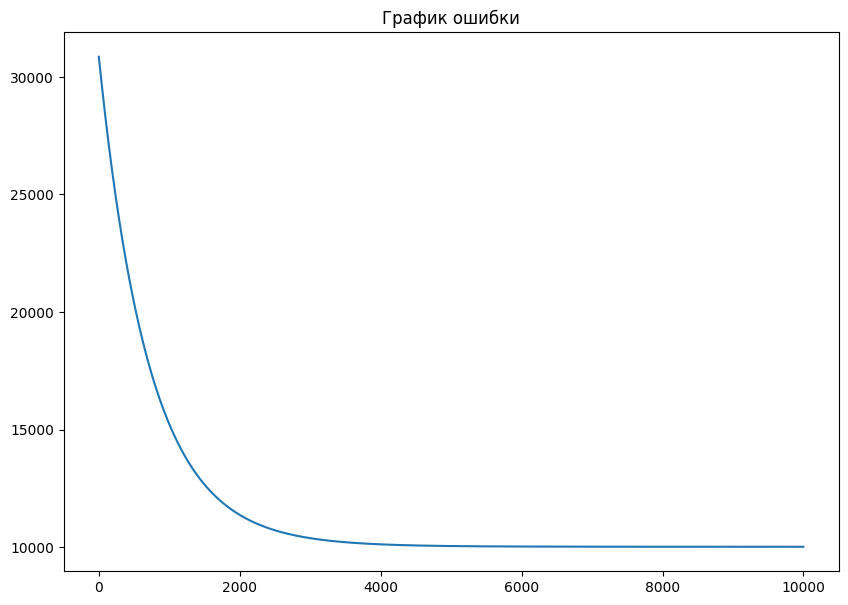

In [8]:
ilr = IterativeLinearRegression(learning_rate=1, iters=10000)
train_history = ilr.fit(x_array, y_array)
predictions = ilr.predict(x_array)

print('Number of iters: ', len(train_history))

#визуализация процесса обучения
plt.plot(np.arange(len(train_history)), train_history)
plt.title('График ошибки')


calculate_significance(y_array, predictions, x_array.shape[1] - 1)

In [9]:
#подобранные веса
print('ILR weights: ', ilr.weights)

ILR weights:  [[125.45448927]
 [  3.21769548]
 [-28.9370523 ]
 [ 11.8512848 ]
 [ 60.85418962]
 [  2.9385353 ]
 [ -0.25458015]]


In [10]:
ols = OrdinaryLeastSquares()
ols.fit(x_array, y_array)
ols_predictions = ols.predict(x_array)

calculate_significance(y_array, ols_predictions, x_array.shape[1] - 1)

{'p-value': array([2.22044605e-16]),
 'F stat': array([270.27116414]),
 'r_squared': array([0.3514102]),
 'adj_r_squared': array([0.34989278]),
 'rmse': array([100.05933419]),
 'std': array([124.2431778])}

In [11]:
print('OLS weights: ', ols.weights)

OLS weights:  [[125.613     ]
 [  3.18559433]
 [-28.70572394]
 [ 11.28355533]
 [ 61.39632906]
 [  2.96481203]
 [ -0.21574707]]


### Квантильная регрессия

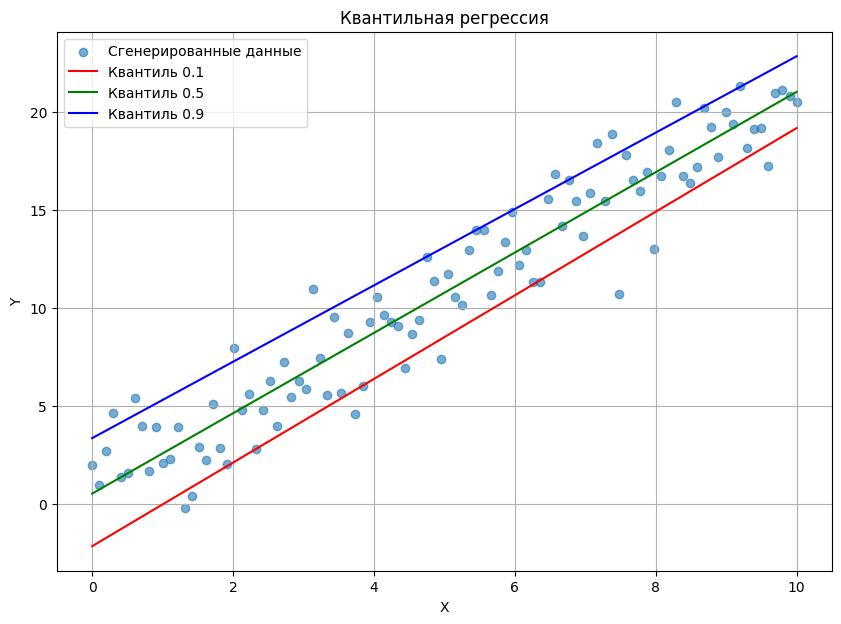

In [12]:
# Генерируем синтетические данные с линейной зависимостью и шумом
np.random.seed(42)
X = np.linspace(0, 10, 100)
Y = 2 * X + 1 + np.random.normal(0, 2, size=X.shape)

# Определяем функцию квантильных потерь
def quantile_loss(weights, X, Y, quantile):
    """
    Вычисляет квантильные потери для заданного набора весов, данных и уровня квантиля.

    Параметры:
    weights (numpy.ndarray): Веса модели.
    X (numpy.ndarray): Значения признаков.
    Y (numpy.ndarray): Фактические значения.
    quantile (float): Уровень квантиля (от 0 до 1).

    Возвращает:
    float: Квантильные потери.
    """
    # Добавляем свободный член
    X_with_bias = np.vstack([np.ones_like(X), X]).T
    y_pred = np.dot(X_with_bias, weights)
    error = Y.reshape(-1, 1) - y_pred.reshape(-1, 1)
    loss = np.sum(np.maximum(quantile * error, (quantile - 1) * error))
    return loss

from scipy.optimize import minimize

def get_quantile_model(X, Y, quantile=0.5):
    """
    Находит веса для модели квантильной регрессии.

    Параметры:
    X (numpy.ndarray): Значения признаков.
    Y (numpy.ndarray): Фактические значения.
    quantile (float): Квантиль (от 0 до 1).

    Возвращает:
    numpy.ndarray: Веса модели.
    """
    # Начальное приближение весов (свободный член и коэффициент для X)
    initial_weights = np.array([0.0, 0.0])
    # Используем minimize для поиска весов, минимизирующих квантильные потери
    result = minimize(quantile_loss, initial_weights, args=(X, Y, quantile))
    return result.x

# Обучаем модели квантильной регрессии для разных квантилей
quantiles = [0.1, 0.5, 0.9]
predictions = {}

for q in quantiles:
    # Получаем веса для текущего квантиля
    weights = get_quantile_model(X, Y, quantile=q)
    # Добавляем сдвиг к X для предсказания
    X_with_bias = np.vstack([np.ones_like(X), X]).T
    # Делаем предсказания, используя полученные веса
    predictions[q] = np.dot(X_with_bias, weights)


# Визуализируем результаты
plt.figure(figsize=(10, 7))
plt.scatter(X, Y, label='Сгенерированные данные', alpha=0.6)

colors = ['r', 'g', 'b']
for i, q in enumerate(quantiles):
    plt.plot(X, predictions[q], color=colors[i], label=f'Квантиль {q}')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Квантильная регрессия')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Определим функцию квантильных потерь, которая работает с X уже с bias
def quantile_loss_adapted(weights, X_with_bias, Y, quantile):
    y_pred = np.dot(X_with_bias, weights)
    error = Y.reshape(-1, 1) - y_pred.reshape(-1, 1)
    loss = np.sum(np.maximum(quantile * error, (quantile - 1) * error))
    return loss

# Адаптируем get_quantile_model для работы с нашим x_array (с bias) и y_array
def get_quantile_model_adapted(X_with_bias, Y, quantile=0.5):
    """
    Находит веса для модели квантильной регрессии,
    принимая X уже с добавленным смещением.

    Параметры:
    X_with_bias (numpy.ndarray): Матрица признаков с добавленным смещением.
    Y (numpy.ndarray): Фактические значения.
    quantile (float): Уровень квантиля (от 0 до 1).

    Возвращает:
    numpy.ndarray: Веса модели.
    """
    # Инициализация весов (с учетом всех признаков + bias)
    initial_weights = np.random.rand(X_with_bias.shape[1])

    # Используем minimize для поиска весов, минимизирующих квантильные потери
    result = minimize(quantile_loss_adapted, initial_weights, args=(X_with_bias, Y, quantile))
    return result.x

# Обучаем модель для квантиля 0.5
weights_qr = get_quantile_model_adapted(x_array, y_array, quantile=0.5)

# Выводим полученные веса
print("Веса квантильной регрессии (q=0.5):", weights_qr)

# Делаем предсказания на обучающей выборке с полученными весами
predictions_qr = np.dot(x_array, weights_qr)

# Вычисляем квантильные потери на обучающей выборке с полученными весами
# Use the adapted quantile_loss_adapted function which handles X with bias
loss_qr = quantile_loss_adapted(weights_qr, x_array, y_array, quantile=0.5)

print(f"Квантильные потери (q=0.5) на обучающей выборке: {2*loss_qr/len(predictions_qr)}")

Веса квантильной регрессии (q=0.5): [106.74926521   4.07950533 -24.43050279   1.75501861  58.43935565
   1.10597504   0.80296521]
Квантильные потери (q=0.5) на обучающей выборке: 73.00908455427685


### Визуализация предсказаний квантильной регрессии

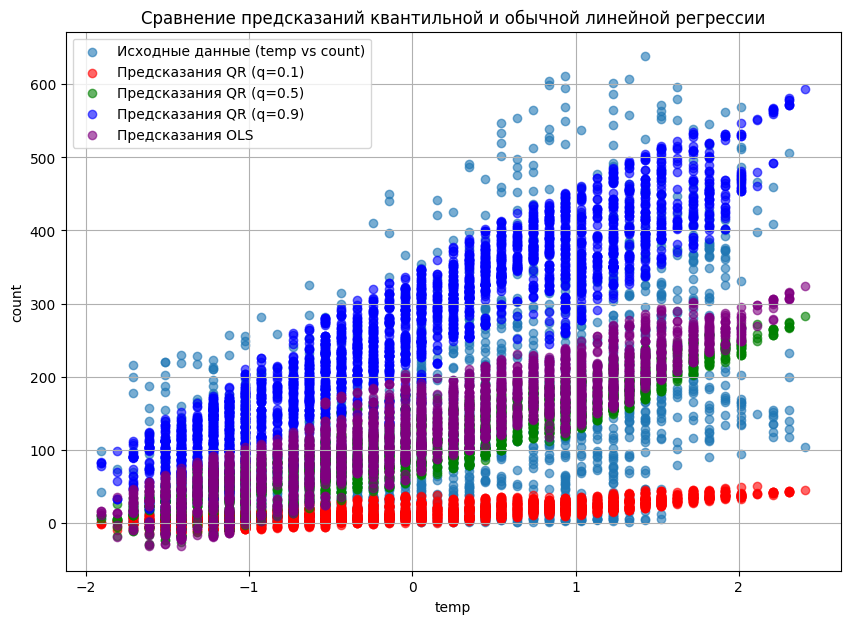

In [14]:
# Визуализация предсказаний квантильной регрессии для разных квантилей на одном признаке (например, temp)
plt.figure(figsize=(10, 7))
# Используем признак 'temp' для визуализации (индекс 4 в x_array, так как bias - индекс 0)
plt.scatter(x_array[:, 4], y_array, label='Исходные данные (temp vs count)', alpha=0.6)

# Обучаем модели для разных квантилей
quantiles_to_plot = [0.1, 0.5, 0.9]
predictions_to_plot = {}

for q in quantiles_to_plot:
    # Обучаем модель для текущего квантиля
    weights = get_quantile_model_adapted(x_array, y_array, quantile=q)
    # Делаем предсказания на обучающей выборке с полученными весами
    predictions_to_plot[q] = np.dot(x_array, weights)

# Визуализируем предсказания для каждого квантиля
colors = ['red', 'green', 'blue']
for i, q in enumerate(quantiles_to_plot):
    plt.scatter(x_array[:, 4], predictions_to_plot[q].reshape(-1, 1), color=colors[i], label=f'Предсказания QR (q={q})', alpha=0.6)

# Добавляем предсказания OLS
plt.scatter(x_array[:, 4], ols_predictions, color='purple', label='Предсказания OLS', alpha=0.6)


plt.xlabel('temp')
plt.ylabel('count')
plt.title('Сравнение предсказаний квантильной и обычной линейной регрессии')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Метрики для Ordinary Least Squares (OLS)
ols_rmse = np.sqrt(mean_squared_error(y_array, ols_predictions))
ols_mae = mean_absolute_error(y_array, ols_predictions)
ols_r2 = r2_score(y_array, ols_predictions)

print("--- Метрики для Ordinary Least Squares (OLS) ---")
print(f"RMSE: {ols_rmse}")
print(f"MAE: {ols_mae}")
print(f"R2 Score: {ols_r2}")
print("-" * 40)

# Метрики для Quantile Regression (q=0.5)
qr_rmse = np.sqrt(mean_squared_error(y_array, predictions_qr))
qr_mae = mean_absolute_error(y_array, predictions_qr)
qr_r2 = r2_score(y_array, predictions_qr)


print("--- Метрики для Quantile Regression (q=0.5) ---")
print(f"RMSE: {qr_rmse}")
print(f"MAE: {qr_mae}")
print(f"R2 Score: {qr_r2}")
print("-" * 40)

--- Метрики для Ordinary Least Squares (OLS) ---
RMSE: 100.05933418697649
MAE: 74.80012487209922
R2 Score: 0.35141019851906874
----------------------------------------
--- Метрики для Quantile Regression (q=0.5) ---
RMSE: 102.47603402903854
MAE: 73.00908455427685
R2 Score: 0.3197014949714715
----------------------------------------


### Исследование мультиколлинеарности

In [16]:
import random

def feature_generator(curr_df, feature_list):
    """
    Генерируем случайный линейно зависимый признак из нашего датафрейма
    """
    random_coll = random.sample(feature_list, 2)
    new_feature = random.choice([("sum " + " ".join(random_coll),
        curr_df[random_coll[0]] + curr_df[random_coll[1]]),
        ("scale " + random_coll[0], 2 * curr_df[random_coll[0]]),
        ('div '+" ".join(random_coll), curr_df[random_coll[0]] - curr_df[random_coll[1]]),
        ('scale+sum '+ " ".join(random_coll), 2 * curr_df[random_coll[0]] + curr_df[random_coll[1]])
    ])

    name = new_feature[0]
    new_feature = new_feature[1] + 1e-7*np.random.randn(*curr_df[random_coll[0]].shape)
    return new_feature, name

Суть эксперимента - проверить OLS модель при обучении с линейно-зависимыми признаками.
Для этого на протяжении 10 экспериментов генерируем с помощью функции **feature_generator** линейно зависимый признак от исходных признаков и добавляем ее в наш датафрейм. Далее обучаем модель и смотрим на норму весов и ошибку модели. Мы ожидаем увидеть сильную флуктуацию в весах модели и в ошибке на тестовой выборке. Это покажет нам неустойчивость OLS модели к мультиколлинеарности.

In [17]:
from numpy import linalg
from tqdm import tqdm
from copy import deepcopy

original_features = ['holiday', 'humidity', 'summer', 'temp', 'windspeed', 'workingday']
train_features = ['holiday', 'humidity', 'summer', 'temp', 'windspeed', 'workingday']

scaled_df_copy = deepcopy(scaled_df)

total_experiements = 10

weights_norm_list = []
error_list = []
r_squared_list = []
iters_amount_list = []
names_new_features = []


for i in tqdm(range(total_experiements)):
    if i >= 1:
        feature_name = f'new_feature_{i}'
        scaled_df_copy[feature_name], name = feature_generator(scaled_df_copy, original_features)
        train_features.append(feature_name)
        names_new_features.append(name)
    # print(train_features)

    # делим нашу выборку на обучающую и тестовую
    X_train, X_test, y_train, y_test = train_test_split(scaled_df_copy[train_features], scaled_df_copy['count'], test_size=0.5, random_state=42)

    # подготавливаем обучающую выборку
    bias_term = np.ones((len(X_train), 1))
    x_train = np.concatenate([bias_term, X_train], axis=1)
    y_train = np.array(y_train).reshape(-1,1)

    # подготавливаем тествую выборку
    bias_term = np.ones((len(X_test), 1))
    x_test = np.concatenate([bias_term, X_test], axis=1)
    y_test = np.array(y_test).reshape(-1,1)

    # обучаем аналитическим методом линейную регрессию
    ols = OrdinaryLeastSquares()
    ols.fit(x_train, y_train)
    train_preds = ols.predict(x_train)
    test_preds = ols.predict(x_test)

    # рассчитываем среднее весов
    if i == 1:
      print()
      for j in list(zip(['bias']+train_features, ols.weights)):
        print(j[0], ' ', j[1][0])

    weights_sum = np.mean(np.abs(ols.weights))
    # рассчитываем ошибку модели на тестовой выборке
    mse_error = 1/len(x_test) * np.sum((test_preds - y_test)**2)
    # print(calculate_significance(y_test, test_preds, x_test.shape[1] - 1))
    r_squared = calculate_significance(y_train, train_preds, x_train.shape[1] - 1)['adj_r_squared']

    r_squared_list.append(r_squared)
    weights_norm_list.append(weights_sum)
    error_list.append(mse_error)
    iters_amount_list.append(len(train_history))

    # print()

100%|██████████| 10/10 [00:00<00:00, 100.55it/s]


bias   126.88455491757486
holiday   -6515255.71875
humidity   -31.489814385888167
summer   16.289316860697
temp   60.5982197955891
windspeed   3.5475267542060465
workingday   -6515258.03125
new_feature_1   6515256.75


Мы видим, что ошибка и веса действительно начинают флуктуировать. А коэфициент детерминации явно показывает сильное переобучение модели.

['sum holiday workingday', 'scale+sum humidity holiday', 'scale+sum humidity holiday', 'sum humidity holiday', 'scale summer', 'scale+sum holiday summer', 'div summer workingday', 'div holiday summer', 'scale temp']


Text(0.5, 1.0, '$R^2$')

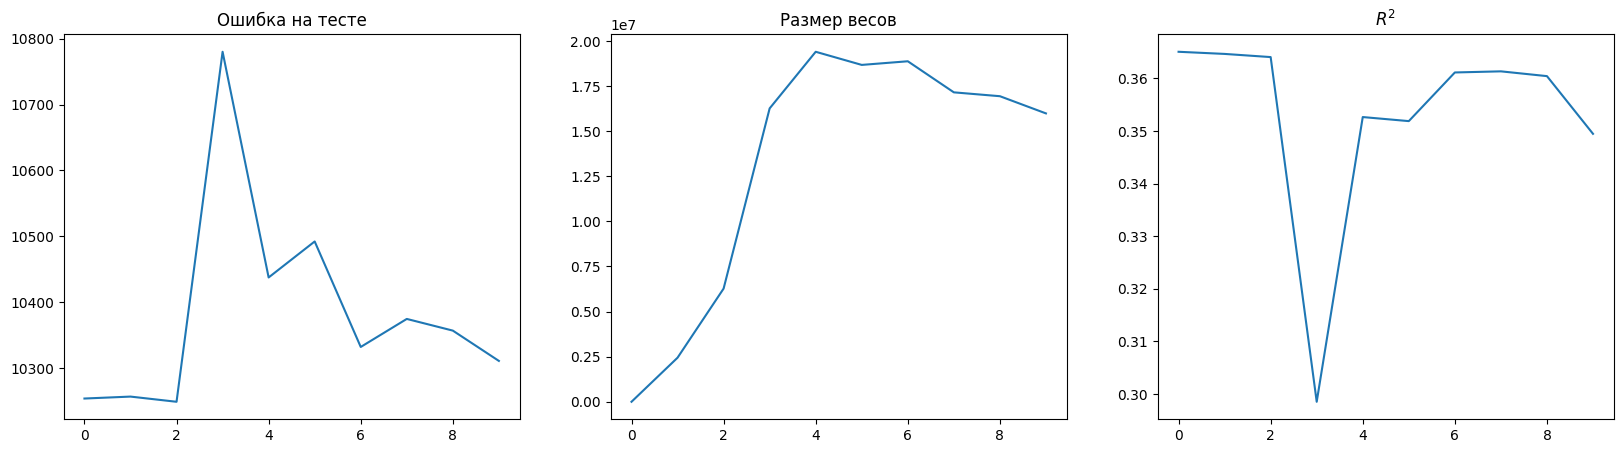

In [18]:
print(names_new_features)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

ax1.plot(list(range(total_experiements)), error_list)
ax1.set_title('Ошибка на тесте')

ax2.plot(list(range(total_experiements)), weights_norm_list)
ax2.set_title('Размер весов')

ax3.plot(list(range(total_experiements)), r_squared_list)
ax3.set_title('$R^2$')

### Интерпретируемое машинное обучение

На практике, линейную регрессию сам никто не пишет - используют готовые библиотеки. Так как ключевое свойство линейных моделей - интерпретируемость и возможность оценивать наш уровень доверия к таким моделям, нам необходимо множество статистик и метрик, которые позволят нам достаточно точно оценить качество нашей модели. Ключевой библиотекой с реализованными линейными моделями является **statmodels**.

In [19]:
#формирование данных для модели
x_array = scaled_df[feature_names]
#добавление вектора смещения
x_array = sm.add_constant(x_array)
y_array = scaled_df['count']

#обучение модели, hasconst - то что мы добавили вектор смещения в модель
ols_model = sm.OLS(y_array, x_array, hasconst=True)
results = ols_model.fit()

#описание интерпретации таблички
#https://www.geeksforgeeks.org/interpreting-the-results-of-linear-regression-using-ols-summary/
#https://habr.com/ru/articles/681218/

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     270.3
Date:                Sun, 28 Sep 2025   Prob (F-statistic):          5.70e-277
Time:                        16:59:56   Log-Likelihood:                -18074.
No. Observations:                3000   AIC:                         3.616e+04
Df Residuals:                    2993   BIC:                         3.620e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        125.6130      1.829     68.680      0.000     122.027     129.199
holiday        3.1856      1.883      1.692      0.091      -0.506       6.878
humidity     -28.7057      1.989    -14.430      0.000     -32.606     -24.805
summer        11.2836      2.128      5.302      0.000       7.111      15.456
temp          61.3963      2.082     29.493      0.000      57.315      65.478
windspeed      2.9648      1.910      1.552      0.121      -0.780       6.709
workingday    -0.2157      1.890     -0.114      0.909      -3.922       3.490
==============================================================================
Omnibus:                      378.392   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              592.267
Skew:                           0.886   Prob(JB):                    2.46e-129
Kurtosis:                       4.264   Cond. No.                         1.82
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Практикум

In [20]:
!wget https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_train.csv
!wget https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_test.csv

--2025-09-28 16:59:56--  https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460676 (450K) [text/plain]
Saving to: ‘house_prices_train.csv.2’

house_prices_train. 100%[===================>] 449.88K  --.-KB/s    in 0.006s  

2025-09-28 16:59:56 (68.9 MB/s) - ‘house_prices_train.csv.2’ saved [460676/460676]

--2025-09-28 16:59:56--  https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
H

In [21]:
df = pd.read_csv('house_prices_train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [22]:
num_features = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
                'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
                '1stFlrSF','2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
                'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
                'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
                'GarageCars', 'GarageArea', 'WoodDeckSF','OpenPorchSF',
                'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
                'MiscVal', 'MoSold', 'YrSold']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df[num_features], df['SalePrice'], test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((1168, 32), (292, 32))

### Сделайте стандартизацию/заполните пустые значения/исследуйте на выбросы данные признаков обучающей и тестовой выборки

In [24]:
### CODE HERE

### Воспользоваться методом OLS библиотеки statsmodels для рассчета коэфициентов линейной регрессии

In [25]:
### CODE HERE

### Выберите переменные, которые статистически положительно связаны с ценой на дом.

In [26]:
### CODE HERE

### Оцените модель- метрик $R^2$ на обучении и RMSE на тестовой выборке. Что мы можем сказать по ошибке?

In [27]:
### CODE HERE

### Придумайте какой-нибудь хороший новый признак. Смогли ли вы снизить ошибку на обучении за счет него?

In [28]:
### CODE HERE

### В нашей модели много признаков. Возможно ли нам уменьшить количеcтво признаков, при этом сохранив качество модели?

In [29]:
### CODE HERE